# Spike Sorting by Clustering


In this lab you'll build a basic spike sorting algorithm for electrophysiological recordings like those you might collect with a tetrode. The model is inspired by [MountainSort](https://github.com/flatironinstitute/mountainsort5), a popular spike sorting algorithm. We'll fit the model to synthetic data simulated with [SpikeInterface](https://github.com/SpikeInterface/spikeinterface), a tool that can generate realistic data with ground truth spike times.

In [ ]:
# First, import necessary libraries.
import numpy as np
import numpy.random as npr
from scipy.io import loadmat
import scipy.signal as signal
import scipy.stats as stats
from scipy.ndimage import gaussian_filter1d
from sklearn.neighbors import NearestNeighbors
from tqdm.auto import trange
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

import seaborn as sns
sns.set_context("notebook")

# Environment Setup

## Download the synthetic data

In [ ]:
%%capture
# !wget -nc https://www.dropbox.com/s/tq0auevkswaa09y/sim_binary.imec.ap.bin
# !wget -nc https://www.dropbox.com/s/j0xcqk7v9n0fzc7/eMouseGroundTruth.mat

In [ ]:
# Load the data. It's stored a binary file of int16's
sample_freq = 30000             # sampling frequency
spike_width = 81                # width of a spike, in samples
plot_slice = slice(0, 6000)     # 200ms window of frames to plot
num_channels = 64               # number of channels on the probe

raw_data = np.fromfile("sim_binary.imec.ap.bin", dtype=np.int16).reshape(-1, num_channels)
raw_data = raw_data.T           # Transpose to be consistent with notes
_, num_samples = raw_data.shape
timestamps = np.arange(num_samples) / sample_freq

In [ ]:
# Load the ground truth labels
ground_truth = loadmat("eMouseGroundTruth.mat", squeeze_me=True)
true_labels = ground_truth["gtClu"]
true_inds = ground_truth["gtRes"]
n_units = true_labels.max()
assert np.all(np.unique(true_labels) == np.arange(1, n_units + 1))

In [ ]:
#@title Define some helper functions for plotting (run this cell)
def plot_data(timestamps,
              data,
              plot_slice=plot_slice,
              true_labels=None,
              true_times=None,
              unit_channels=None,
              spike_width=spike_width,
              scale=10,
              figsize=(12, 9),
              cmap="jet"):
    n_channels, n_samples = data.shape
    cmap = get_cmap(cmap) if isinstance(cmap, str) else cmap

    plt.figure(figsize=figsize)
    plt.plot(timestamps[plot_slice],
             data.T[plot_slice] - scale * np.arange(n_channels),
             '-k', lw=1)

    if not any(x is None for x in [true_labels, true_times, unit_channels]):
        # Plot the ground truth spikes and assignments
        n_units = true_labels.max()
        in_slice = (true_times >= plot_slice.start) & (true_times < plot_slice.stop)
        labels = true_labels[in_slice]
        times = true_times[in_slice]
        for i in range(n_units):
            i_channels = unit_channels[i]
            for t in times[labels == i + 1]:
                window = slice(t - spike_width // 2, t + spike_width // 2)
                plt.plot(timestamps[window],
                         data.T[window, i_channels] - scale * np.arange(n_channels)[i_channels],
                         color=cmap(i / (n_units-1)),
                         alpha=0.5,
                         lw=2)

    plt.yticks(-scale * np.arange(1, n_channels+1, step=2),
            np.arange(1, n_channels+1, step=2) + 1)
    plt.xlabel("time [s]")
    plt.ylabel("channel")
    plt.xlim(timestamps[plot_slice.start], timestamps[plot_slice.stop])
    plt.ylim(-scale * n_channels, scale)


def plot_templates(templates,
                   indices,
                   scale=0.1,
                   n_cols=8,
                   panel_height=6,
                   panel_width=1.25,
                   colors=('k',),
                   label="neuron"):
    n_subplots = len(indices)
    n_cols = min(n_cols, n_subplots)
    n_rows = int(np.ceil(n_subplots / n_cols))

    fig, axs = plt.subplots(n_rows, n_cols,
                            figsize=(panel_width * n_cols, panel_height * n_rows),
                            sharex=True, sharey=True)

    n_units, n_channels, spike_width = templates.shape
    timestamps = np.arange(-spike_width // 2, spike_width//2) / sample_freq
    for i, (ind, ax) in enumerate(zip(indices, np.ravel(axs))):
        color = colors[i % len(colors)]
        ax.plot(timestamps * 1000,
                templates[ind].T - scale * np.arange(n_channels),
                '-', color=color, lw=1)

        ax.set_title("{} {:d}".format(label, ind + 1))
        ax.set_xlim(timestamps[0] * 1000, timestamps[-1] * 1000)
        ax.set_yticks(-scale * np.arange(n_channels+1, step=4))
        ax.set_yticklabels(np.arange(n_channels+1, step=4) + 1)
        ax.set_ylim(-scale * n_channels, scale)

        if i // n_cols == n_rows - 1:
            ax.set_xlabel("time [ms]")
        if i % n_cols == 0:
            ax.set_ylabel("channel")

        # plt.tight_layout(pad=0.1)


## Plot the raw data
It's a 64-dimensional time series of voltage measurements for each channel in units of microvolts ($\mu$V). Here we plot a 200ms window of data. The `scale` parameter specifies the spacing between channels in the same units as the data.  For this synthetic data, the noise is on the order of 10-20$\mu$V, and the spikes are on the order of 100$\mu$V.

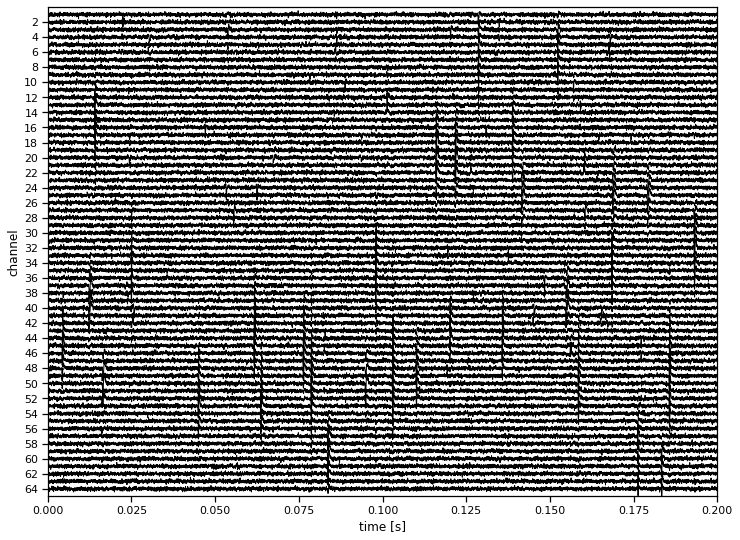

In [ ]:
plot_data(timestamps, raw_data, scale=100)

# Part 1: Preprocessing the data

## Problem 1a: Bandpass filtering
First we will bandpass filter each channel from 300Hz to 2kHz to isolate spiking content. We'll use a 10th order Butterworth filter.

Use `signal.butter` and `signal.sosfilt` to do this (note that `signal` is an alias for `scipy.signal`; see above). Try calling `help(signal.butter)` or Googling it for more information on the function signature and outputs. The `sample_freq` is specified above.

In [ ]:
# construct a Butterworth bandpass filter
order = 10
sos = signal.butter(order, [300, 2000], 'bandpass', fs=sample_freq, output='sos')

Plot the frequency response of the filter

Text(0.5, 1.0, 'Butterworth filter frequency response')

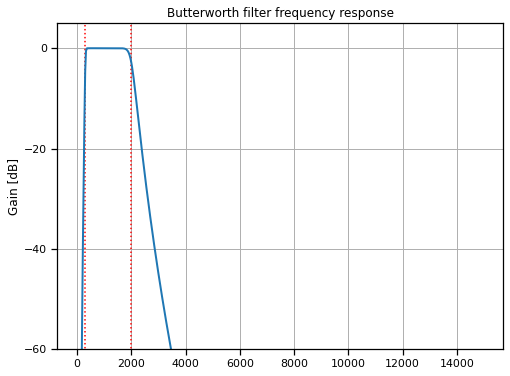

In [ ]:
# This function evaluates the filter response
# at a grid of input frequencies from 0 to the Nyquist frequency
# (1/2 the sampling frequency). The response is given
# as a complex number for each input frequency, where the square
# of the magnitude is the power at that frequency.
freqs, response = signal.sosfreqz(sos, fs=sample_freq)

# convert the response to decibels and truncate lower end.
# (see, e.g., https://en.wikipedia.org/wiki/Decibel)
response_db = 20 * np.log10(np.maximum(np.abs(response), 1e-5))

# Plot the response.
plt.figure(figsize=(8, 6))
plt.plot(freqs, response_db, lw=2)
plt.vlines([300, 2000], *plt.ylim(), colors='r', ls=':')
plt.ylim(-40, 5)
plt.grid(True)
plt.yticks([0, -20, -40, -60])
plt.ylabel('Gain [dB]')
plt.title('Butterworth filter frequency response')

Apply the filter to the raw data using `signal.sosfilt`.

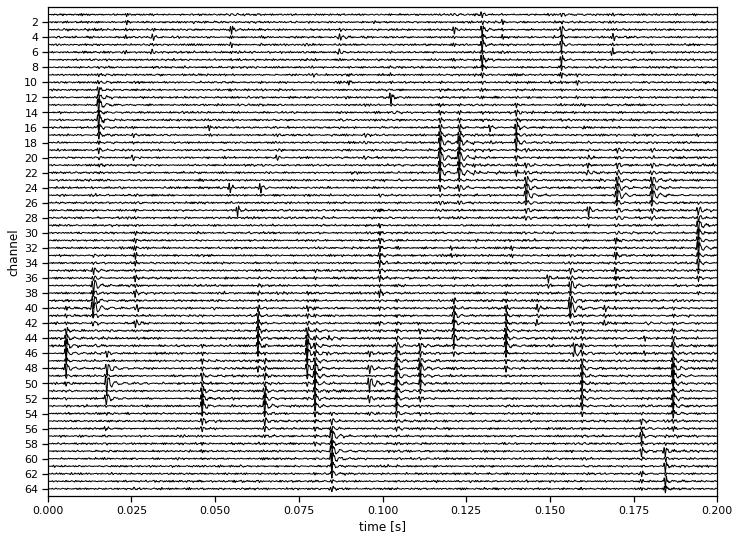

In [ ]:
filtered_data = signal.sosfilt(sos, raw_data, axis=1)

# Plot the result. It should be much cleaner than the raw data.
plot_data(timestamps, filtered_data, scale=100)

## Problem 1b: Decorrelate and standardize the signal

Bandpass filtering effectively centered the data for us (think about why that is), but there are still instantaneous noise correlations between the channels that will invalidate our modeling assumptions below.  We'll try to counteract that here.

Let $x \in \mathbb{R}^C$ denote a random variable denoting a vector of voltage measurements across the $C$ channels. Let $\mathrm{Cov}(x) = \Sigma$ denote the (symmetric) covariance matrix of $x$, and define $\tilde{x} = \Sigma^{-1/2} x$. Then $\mathrm{Cov}(\tilde{x}) = \Sigma^{-1/2} \Sigma (\Sigma^{-1/2})^\top = I$. Multiplying by the inverse square root of the covariance yields a random variable with uncorrelated channels and unit variance along each channel.

We'll use an empirical estimate of the covariance matrix instead. Let $\hat{\Sigma} = \frac{1}{T} \sum_{t=1}^T x_t x_t^\top$ denote the empirical covariance matrix, where $x_t$ is the vector of voltage measurements at time $t$ across all channels. $\hat{\Sigma} = U S V^T$ denote its signal value decomposition.  Since the covariance matrix is symmetric, $U = V$.  The inverse square root is given by,
\begin{align}
\hat{\Sigma}^{-1/2} = V S^{-1/2} V^T.
\end{align}

We will call the transformed data $\tilde{x}_t = \hat{\Sigma}^{-1/2} x_t$ the `data` for short, since it's what we'll be working with from here on.



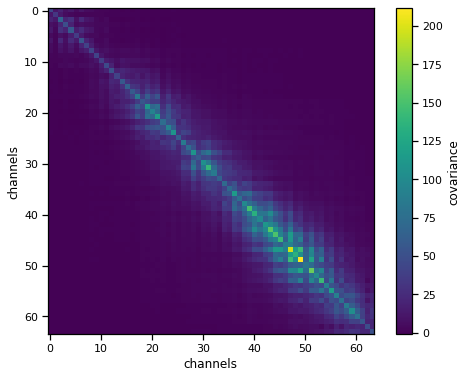

In [ ]:
mean = np.mean(filtered_data, axis=0)
cov = np.cov(filtered_data)

plt.figure(figsize=(8, 6))
plt.imshow(cov)
plt.xlabel("channels")
plt.ylabel("channels")
plt.colorbar(label="covariance")

In [ ]:
U, S, VT = np.linalg.svd(cov)
inverse_sqrt_cov = (U * 1/np.sqrt(S)) @ VT

# Multiply the filtered data by the inverse square root of the covariance
data = inverse_sqrt_cov @ filtered_data

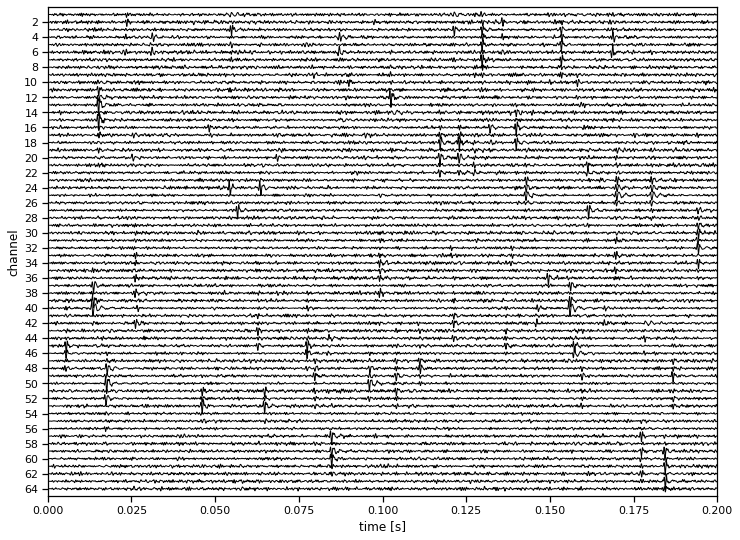

In [ ]:
plot_data(timestamps, data, scale=10)

In [ ]:
# Cleanup: remove the filtered data since we no longer need it
del filtered_data

# Part 2: Find putative spikes

## Problem 2a: Find negative peaks in the data

We're looking for peaks in the negative voltage for each channel. The peaks should stand out from the noise---a reasonable threshold is 4 standard deviations---and they should be well separted---a reasonable distance is 5ms.  Use the `signal.find_peaks` function to extract negative peaks for each channel.

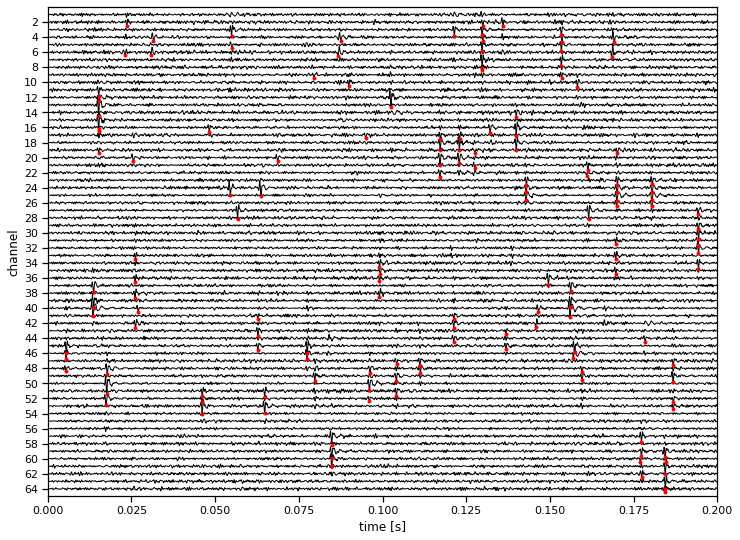

In [ ]:
# Use scipy.signal.find_peaks to find candidate spike times
distance_ms = 0.005  # time between spikes (in seconds)
height = 4           # standard deviations to define a peak
per_ch_spike_inds = []
for ch in trange(num_channels):
    ch_spike_inds, _ = \
        signal.find_peaks(-data[ch],
                          height=height,
                          distance=distance_ms * sample_freq)
    per_ch_spike_inds.append(ch_spike_inds)

plot_data(timestamps, data)
for ch, ch_spike_inds in enumerate(per_ch_spike_inds):
    plt.plot(timestamps[ch_spike_inds],
             data[ch, ch_spike_inds] - 10 * ch,
             'r.',)

## Problem 2b: Combine spike times that are nearly coincident across channels

We'll do this in a few steps:

1. Count the number of spikes in each time bin with `np.histogram` applied to the concatenated `per_channel_spike_inds`.
2. Smooth the `total_spike_counts` with `gaussian_filter_1d` using a filter width of 0.1ms.
3. Plot the smoothed histogram and eyeball a lower bound to declare a spike.
4. Use `find_peaks` again, this time on the smoothed total spike counts and with a distance threshold of 1ms.

Found 32115 putative spikes


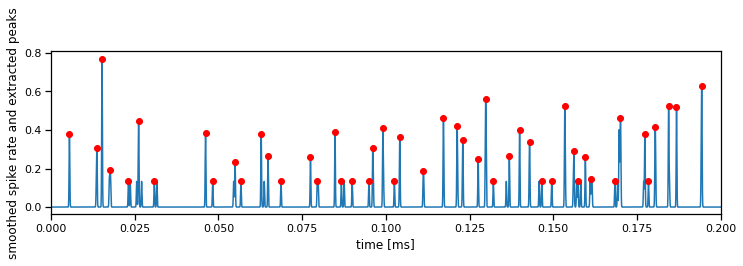

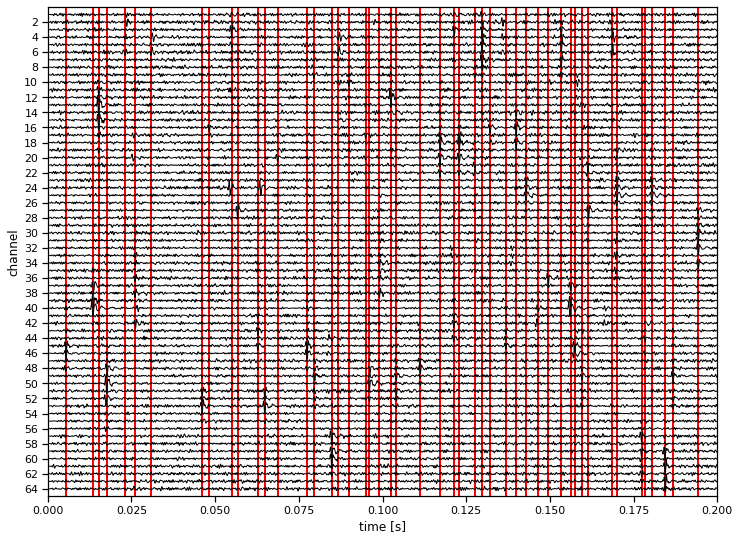

In [ ]:
# combine nearly coincident spikes across channels
# allow a delay of a fraction of the refractory period
bins = np.arange(num_samples + 1)
total_spike_counts, _ = np.histogram(np.concatenate(per_ch_spike_inds), bins)

# Do a little Gaussian smoothing to allow for jitter in spike time across channels
jitter_width = 0.0001  # in seconds
total_spike_counts = gaussian_filter1d(total_spike_counts.astype(float),
                                       jitter_width * sample_freq)

# Eyeball a threshold and find peaks
min_height = 0.1   # run with np.inf first and then update with chosen threshold
spike_inds, _ = signal.find_peaks(total_spike_counts,
                                  height=min_height,
                                  distance=0.001 * sample_freq)
num_spikes = len(spike_inds)
print("Found", num_spikes, "putative spikes")

# Plot the smoothed firing rate and extracted peaks
plt.figure(figsize=(12, 3))
in_slice = (spike_inds >= plot_slice.start) & (spike_inds < plot_slice.stop)
plt.plot(timestamps[plot_slice], total_spike_counts[plot_slice])
plt.plot(timestamps[spike_inds[in_slice]], total_spike_counts[spike_inds[in_slice]], 'ro')
plt.xlim([timestamps[plot_slice.start], timestamps[plot_slice.stop]])
plt.xlabel("time [ms]")
plt.ylabel("smoothed spike rate and extracted peaks")

# Plot the data and overlay the spike times to sanity check your results
plot_data(timestamps, data, scale=10)
plt.vlines(timestamps[spike_inds[in_slice]], *plt.ylim(), color='r', lw=2)

In [ ]:
assert num_spikes == 32115, "play with the threshold to ensure you get this number of spikes"

## Collect the spikes into an $S \times C \times D$ array

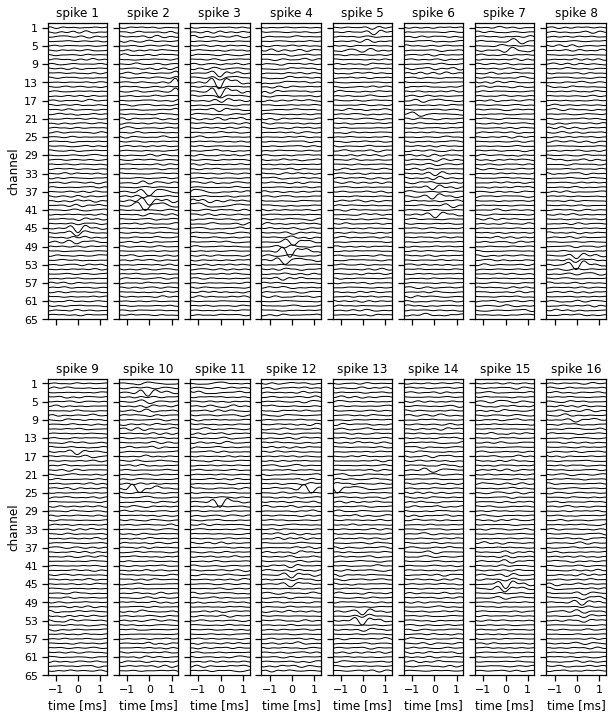

In [ ]:
spikes = np.zeros((num_spikes, num_channels, spike_width))
for i, ind in enumerate(spike_inds):
    window = slice(ind - spike_width // 2, ind + spike_width // 2 + 1)
    spikes[i] = data[:, window]

# we can use our template plotting code to visualize the spikes too
plot_templates(spikes, indices=np.arange(16), scale=10, label="spike")

# Part 3: Write a simple spike sorting algorithm

Recall our simple spike sorting model from lecture.
Let
- $S$ denote the number of (putative) spikes
- $C$ denote the number of channels on the probe.
- $D$ denote the maximum duration (in frames) of a spike.
- $N$ denote the (unknown) number of units (i.e. neurons).
- $K \leq \min\{C, D\}$ denote the dimensionality (i.e. rank) of a single unit's spike waveform.

Our preprocessing steps above yielded an array of spike waveforms, which we denote by $Y \in \mathbb{R}^{S \times C \times D}$.

Our latent variables are,
- $n_s \in \{1, \ldots, N\}$, the neuron label assigned to spike $s$.
- $a_s \in \mathbb{R}_+$, the amplitude of spike $s$.

And our parameters are,
- $W \in \mathbb{R}^{N \times C \times D}$, the normalized waveform of spikes by neuron $n$.
- $\pi \in \Delta_N$, a prior distribution on neurons.

For simplicity, we will treat the following as hyperparameters. Let,
- $\lambda_n \in \mathbb{R}_+$, the rate (inverse scale) of spike amplitudes on neuron $n$.
- $\sigma^2 \in \mathbb{R}_+$, the noise level, which we assume to be constant across channels.

We will set $\lambda_n = 0.01$ to minimally shrink the amplitude estimates, and we set $\sigma^2 = 1$ based on the standardization we did in preprocessing.


## Problem 3a: write a helper function to project onto $\mathcal{S}_K$.

One of the key pieces of our algorithm is solving the following constrained optimization over $\mathcal{S}_K$,
\begin{align}
X^\star &= \mathrm{argmin}_{X \in \mathcal{S}_K} \mathrm{Tr}(A^\top X)
\end{align}
for a target matrix $A \in \mathbb{R}^{C \times D}$. This is equivalent to projecting $A$ onto the set $\mathcal{S}_K$. In lecture we showed that we can solve this problem with the SVD $A = U \mathrm{diag}(\varsigma) V$. Then,
\begin{align}
X^\star &= U_{:K} \mathrm{diag} \left(\tfrac{\varsigma_{:K}}{\|\varsigma_{:K}\|_2} \right) V_{:K}^\top,
\end{align}
where $U_{:K}$ and $V_{:K}$ are the first $K$ columns of $U$ and $V$, and where $\varsigma_{:K}$ are the first $K$ singular values in $\varsigma$.

Write a helper function to compute this projection.


In [ ]:
def project_templates(targets, rank):
    """A helper function to project a target template
    onto the space of rank-K, unit norm matrices via
    truncted SVD.

    Parameters:

    targets:    an NxCxD array of target matrices
    rank:       an integer K <= min(C, D)

    Returns:

    templates:  a NxCxD array where templates[n] is the projection
                of targets[n] onto \mathcal{S}_K, the set of rank-K,
                unit norm matrices.

    """
    assert rank <= min(*targets.shape[-2:])
    U, Sigma, VT = np.linalg.svd(targets, full_matrices=False)
    U, Sigma, VT = U[..., :, :rank], Sigma[..., :rank], VT[..., :rank, :]
    Sigma = Sigma / np.linalg.norm(Sigma, axis=-1, keepdims=True)
    templates = np.einsum('...ck,...k,...kd->...cd', U, Sigma, VT)
    assert np.allclose(np.sum(templates**2, axis=(-1,-2)), 1.0)
    return templates

## Problem 3b: Initialization

Initialize the model parameters as follows:
- Fix $N=100$ as an upper bound on the number of neurons
- Fix $K=3$ as the rank of the templates
- Initialize $W$ by randomly choosing $N$ spike waveforms from $Y$ and projecting them onto $\mathcal{S}_K$ using the function you write in problem 3a.
- Set $\pi$ to the uniform distribution
- Set $\lambda_n = 0.01$ for a broad prior on amplitudes $a_s$
- Set $\sigma^2 = 1$, since we have standardized the data.

In [ ]:
# We'll give our variables human-readable names

# Set the hyperparameters
num_neurons = 100                                               # N
template_rank = 3                                               # K

# Initialize colors to plot each neuron
colors = get_cmap("jet")(npr.rand(num_neurons))

# Initialize the model parameters
neuron_probs = np.ones(num_neurons) / num_neurons               # \pi
amplitude_rates = 0.01 * np.ones(num_neurons)                   # \lambda_n
noise_std = 1.0                                                 # \sigma

# Initialize the templates W.
# Make sure they are low rank and normalized!
npr.seed(0)
inds = npr.choice(num_spikes, size=num_neurons, replace=False)
templates = project_templates(spikes[inds], template_rank)      # W

# Initialize the latent variables.
# (These will be overwritten below, but it's helpful to
#  specification here.)
labels = npr.choice(num_neurons, size=num_spikes)               # n_s
amplitudes = np.ones(num_spikes)                                # a_s

# Pack them into dictionaries
hypers = dict(
    num_neurons=num_neurons,
    template_rank=template_rank,
    amplitude_rates=amplitude_rates,
    noise_std=noise_std
)

params = dict(
    templates=templates,
    neuron_probs=neuron_probs,
)

latents = dict(
    labels=labels,
    amplitudes=amplitudes
)

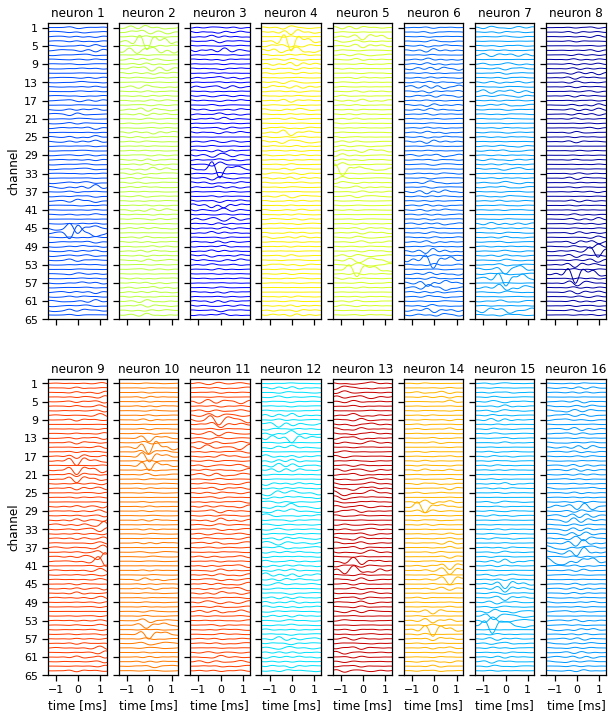

In [ ]:
# Plot the initial templates
plot_templates(params["templates"], np.arange(16), scale=0.1, colors=colors)

## Problem 3c: Write a function to compute the log probability

For the likelihood, we modeled the observed spike waveforms as randomly scaled versions of a neuron's normalized waveform plus additive noise.
\begin{align}
    p(Y \mid W, \{n_s, a_s\}_{s=1}^S, \sigma^2)
    &= \prod_{s=1}^S \prod_{c=1}^C \prod_{d=1}^D \mathcal{N} \left(y_{scd} \mid a_s \cdot w_{n_s cd}, \, \sigma^2 \right).
\end{align}

Taking the log and expanding the Gaussian density,
\begin{align}
    \log p(Y \mid W, \{n_s, a_s\}_{s=1}^S, \sigma^2)
    &=
    \sum_{s=1}^S \sum_{c=1}^C \sum_{d=1}^D
    \left[-\frac{1}{2} \log 2 \pi \sigma^2 -\frac{1}{2\sigma^2} (y_{scd} - a_s \cdot w_{n_s cd})^2 \right] \\
    &=
    -\frac{SCD}{2} \log 2\pi\sigma^2 -\frac{1}{2\sigma^2} \sum_{s=1}^S \|Y_s - a_s W_{n_s}\|_F^2 \\
    &=
    -\frac{SCD}{2} \log 2\pi\sigma^2 -\frac{1}{2\sigma^2} \sum_{n=1}^N \sum_{s:n_s = n} \|Y_s - a_s W_{n}\|_F^2.
\end{align}

We completed the model with priors on the latent variables and parameters. We assumed,
\begin{align}
n_s &\sim \pi \\
a_s \mid n_s &\sim \mathrm{Exp}(\lambda_{n_s})
\end{align}
where $\pi \in \Delta_N$ is a distribution on neurons and $\lambda_n$ is the rate parameter (i.e. the inverse scale) of an exponential distribution on amplitudes. Thus,
\begin{align}
\log p(\{n_s, a_s\}_{s=1}^S) = \sum_{s=1}^S \log \pi_{n_s} + \log \lambda_{n_s} - \lambda_{n_s} a_s.
\end{align}


We assumed uniform priors on $\pi$ and $W_n$, so they will not factor into our log probability calculation.

In [ ]:
def log_probability(spikes, latents, params, hypers):
    """Evaluate the average log joint probability of the spikes,
    latents, and params.
    """
    S, C, D = spikes.shape
    N = hypers["num_neurons"]
    sigma = hypers["noise_std"]
    lmbdas = hypers["amplitude_rates"]

    ns = latents["labels"]
    amps = latents["amplitudes"]
    W = params["templates"]
    pi = params["neuron_probs"]

    # compute the log likelihood, log p(Y | W, \{n_s, a_s\}_{s=1}^S)
    lp = -0.5 * S * C *D * np.log(2 * np.pi * sigma**2)
    for n in range(N):
        Yhat = np.einsum('s,cd->scd', amps[ns == n], W[n])
        lp += -0.5 / sigma**2 * np.sum((spikes[ns == n] - Yhat)**2)

    # compute the log prior probability log p(\{n_s, a_s\})
    lp += np.sum(np.log(pi[ns]))
    lp += np.sum(stats.expon(scale=1/lmbdas[ns]).logpdf(amps))

    # return the average log probability
    return lp / spikes.size

In [ ]:
# Try it!
lp = log_probability(spikes, latents, params, hypers)
assert np.allclose(lp, -1.5218722)

## Problem 3d: Write a function to update for the latent variables

In lecture we derived a coordinate ascent algorithm for MAP estimation of the latent variables and parameters. We showed that for fixed parameters, the optimal spike assignment ($n_s$) and amplitude $a_s$ are,
\begin{align}
n_s &= \mathrm{argmax} \mathcal{L}(n) \\
a_s &= a_s^\star(n_s)
\end{align}
where
\begin{align}
    a_s^\star(n) &= \max\left\{0, \, \mathrm{Tr}(Y_s^\top W_{n}) - \sigma^2 \lambda_{n} \right\} \\
    \mathcal{L}(n) &=
    \frac{1}{2 \sigma^2}\left( a_s^\star(n) \right)^2  + \log \pi_{n}.
\end{align}
Let's implement this update. Remember that $\mathrm{Tr}(Y_s^\top W_n) = \sum_{cd} Y_{scd} W_{ncd}$.

In [ ]:
def update_latent_variables(spikes, params, hypers):
    S, C, D = spikes.shape
    lmbda = hypers["amplitude_rates"]
    sigma = hypers["noise_std"]
    W = params["templates"]
    pi = params["neuron_probs"]

    # compute the optimal amplitudes for each spike and assignment
    amplitudes = np.einsum('scd,ncd->sn', spikes, W)
    # threshold the amplitudes
    amplitudes = np.maximum(0, amplitudes - sigma**2 * lmbda)
    # compute the log probability for each neuron
    lp = 0.5/sigma**2 * amplitudes**2 + np.log(pi)
    # find the most likely neuron labels
    labels = np.argmax(lp, axis=1)
    # get the corresponding amplitude
    amplitudes = amplitudes[np.arange(S), labels]
    # pack the results into a dictionary and return
    return dict(labels=labels, amplitudes=amplitudes)

updating latent variables may take a minute...


Text(0, 0.5, 'num. assigned spikes')

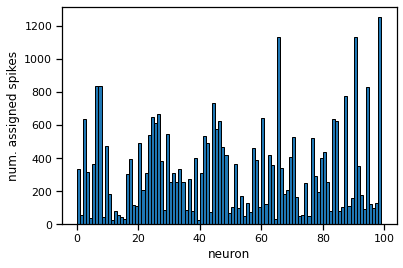

In [ ]:
# Test it! Run one update of the latent variables
print("updating latent variables may take a minute...")
new_latents = update_latent_variables(spikes, params, hypers)

# Plot a histogram of neuron labels
plt.hist(new_latents["labels"], np.arange(num_neurons), ec='k')
plt.xlabel("neuron")
plt.ylabel("num. assigned spikes")

## Problem 3e: Write a function to update the templates

In lecture we showed that the optimal waveforms are the truncated SVD of the average spike waveform assigned to each neuron.  Use your `project_templates` function to implement the following function for updating the templates given the neuron labels and amplitudes.

In [ ]:
def update_templates(spikes, latents, params, hypers):
    # Unpack the parameters
    S, C, D = spikes.shape
    N = hypers["num_neurons"]
    K = hypers["template_rank"]
    ns = latents["labels"]
    amps = latents["amplitudes"]

    targets = np.zeros((N, C, D))
    for n in range(N):
        # compute the average waveform (or something proportional to it)
        targets[n] = np.einsum('scd,s->cd', spikes[ns == n], amps[ns == n])
    templates = project_templates(targets, K)

    # Update the parameters
    new_params = deepcopy(params)
    new_params["templates"] = templates
    return new_params


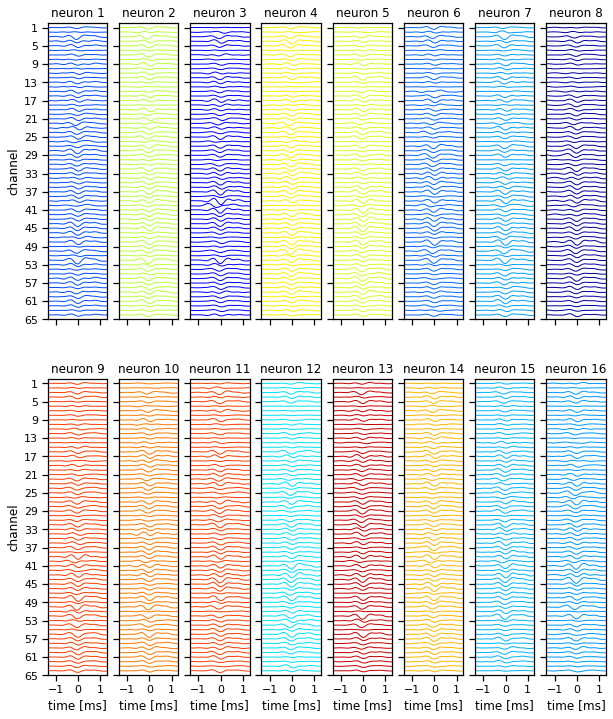

In [ ]:
# Try it! run one update of the templates and see what they look like.
new_params = update_templates(spikes, latents, params, hypers)
plot_templates(new_params["templates"], np.arange(16), colors=colors)

## Problem 3f: Write a function to update the neuron probabilities $\pi$

In lecture you worked out that,
\begin{align}
\pi_n &= \frac{1}{S} \sum_{s=1}^S \mathbb{I}[n_s = n].
\end{align}


In [ ]:
def update_neuron_probs(spikes, latents, params, hypers):
    """Update the neuron assignment probabilites $\pi$, holding
    the latent variables fixed.
    """
    pi = np.bincount(latents["labels"], minlength=hypers["num_neurons"])

    # Return a new copy of the parameters
    new_params = deepcopy(params)
    new_params["neuron_probs"] = pi
    return new_params

## Put it all together

Now we can write a function to perform MAP estimation.

In [ ]:
def update_parameters(spikes, latents, params, hypers):
    params = update_templates(spikes, latents, params, hypers)
    params = update_neuron_probs(spikes, latents, params, hypers)
    return params

def map_estimate(spikes,
                 initial_latents,
                 initial_params,
                 hypers,
                 max_iter=10,
                 tol=1e-3):
    """Find the MAP estimate of the parameters and latent
    variables via coordinate ascent.
    """
    # Initialize the algorithm
    latents = initial_latents
    params = initial_params
    lps = [log_probability(spikes, latents, params, hypers)]

    pbar = trange(max_iter)
    pbar.set_description("LP: {:.4f}".format(lps[0]))
    for itr in pbar:
        # compute the most likely latent variables given current parameters
        latents = update_latent_variables(spikes, params, hypers)
        # compute the most likely parameters given the latent variables
        params = update_parameters(spikes, latents, params, hypers)
        # compute the new log probability
        lps.append(log_probability(spikes, latents, params, hypers))
        # update the progress bar
        pbar.update(1)
        pbar.set_description("LP: {:.4f}".format(lps[-1]))
        # check for convergence
        if abs(lps[-1] - lps[-2]) < tol:
            print("Convergence detected!")
            break

    return np.array(lps), latents, params

Convergence detected!


Text(0, 0.5, 'log probability')

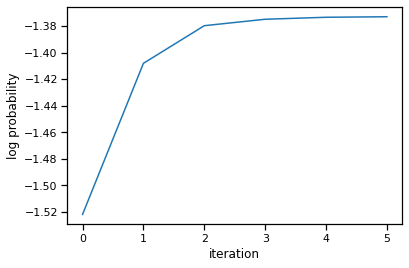

In [ ]:
lps, latents, new_params = map_estimate(spikes, latents, params, hypers)

# Plot the training curve
plt.plot(lps)
plt.xlabel("iteration")
plt.ylabel("log probability")

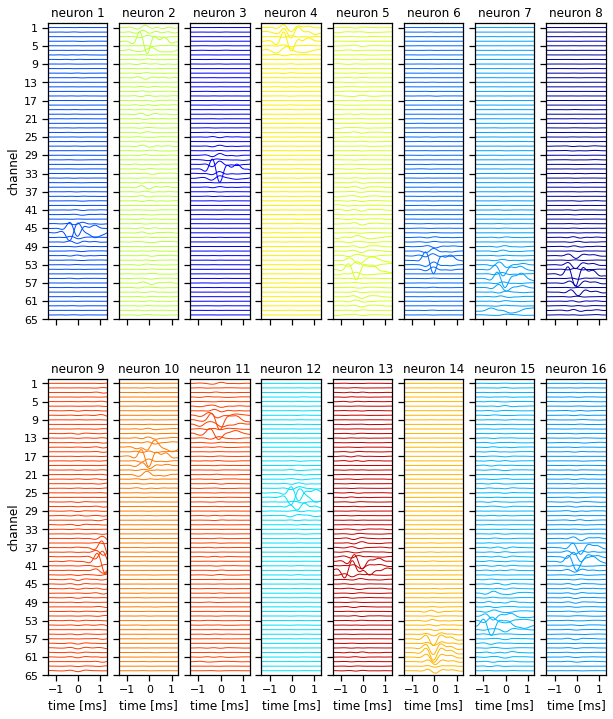

In [ ]:
# Plot some of the learned templates
plot_templates(new_params["templates"], np.arange(16), colors=colors)

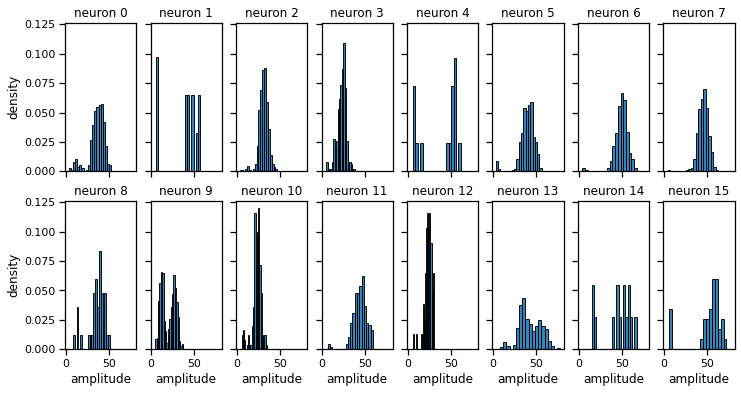

In [ ]:
# Plot the amplitude distributions for a few neurons
def plot_amplitudes(latents, n_rows=2, n_cols=8):
    labels = latents["labels"]
    amps = latents["amplitudes"]

    fig, axs = plt.subplots(n_rows, n_cols, sharex=True, sharey=True,
                            figsize=(12, 6))
    for ind, ax in enumerate(np.ravel(axs)):
        row, col = np.unravel_index(ind, (n_rows, n_cols))
        ax.hist(amps[labels==ind], 20, density=True, edgecolor='k', alpha=0.9)

        if row == n_rows - 1:
            ax.set_xlabel("amplitude")
        if col == 0:
            ax.set_ylabel("density")
        ax.set_title("neuron {}".format(ind))

plot_amplitudes(latents)

You'll probably see some bimodal amplitude histograms. These suggest that some labels actually correspond to multiple true neurons.  In the next section we'll do some basic evaluation of the model outputs.

# Part 4: Evaluation

Compare the inferred spike assignments to the ground truth.

**There is no coding necessary for this part. Instead, you will be asked to discuss ways that you could further evaluate the spike sorting algorithm.**

## See how close our inferred spike times are to the true times

We've written some basic code to check how close the inferred spikes are to the true spike times.  Note that the true spike times are defined as the start of the template, whereas ours are defined as the center. Even after accounting for that, there could be a little offset since we haven't forced our templates to peak in the middle, but we should expect that the time to the nearest true spike should be on the order of a spike width, say 1ms.

number of inferred spikes more than 5ms away from a true spike:  2


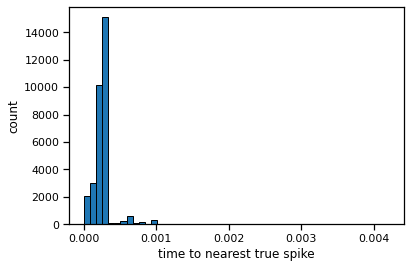

In [ ]:
nn = NearestNeighbors(1).fit(true_inds.reshape(-1, 1))
dists, nearest_inds = nn.kneighbors((spike_inds - spike_width // 2).reshape(-1, 1))
dists, nearest_inds = dists.ravel(), nearest_inds.ravel()
dists_sec = dists.ravel() / sample_freq
nearest_times = true_inds[nearest_inds.ravel()]

plt.hist(dists_sec[dists_sec < 0.005], 50, ec='k')
plt.xlabel("time to nearest true spike")
plt.ylabel("count")
print("number of inferred spikes more than 5ms away from a true spike: ", np.sum(dists_sec > 0.005))

## See how well our inferred labels line up with the true labels

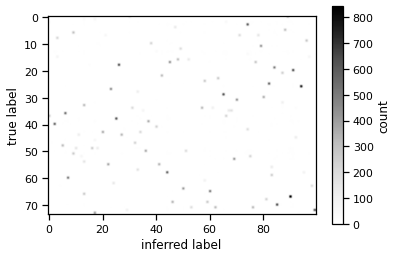

In [ ]:
# First get the label of the nearest true spike
nearest_labels = true_labels[nearest_inds]
num_neurons_true = len(np.unique(true_labels))

# Then compute the overlap matrix, which counts the number of times
# a spike with true label i was assigned label j by our algorithm.
def compute_overlap(labels, true_labels):
    unique_labels = np.unique(labels)
    unique_true_labels = np.unique(true_labels)

    overlap = np.zeros((len(unique_true_labels), len(unique_labels)))
    for i, label_i in enumerate(unique_true_labels):
        for j, label_j in enumerate(unique_labels):
            overlap[i, j] = np.sum((true_labels == label_i) & (labels == label_j))
    return overlap, unique_labels, unique_true_labels

overlap, _, _ = compute_overlap(latents["labels"], nearest_labels)

plt.imshow(overlap, cmap="Greys")
plt.xlabel("inferred label")
plt.ylabel("true label")
plt.colorbar(label="count")


## The labels are all shuffled! Use a simple heuristic to align them.
We permute the inferred labels by finding the true label with the most overlap and then sorting.

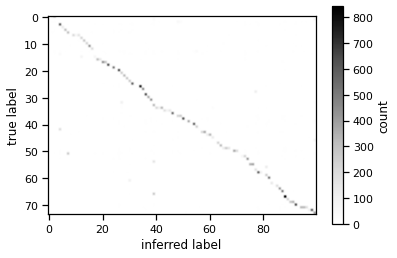

In [ ]:
# Permute the inferred labels to align with the true labels
permutation = np.argsort(np.argmax(overlap, axis=0))

plt.imshow(overlap[:, permutation], cmap="Greys")
plt.xlabel("inferred label")
plt.ylabel("true label")
plt.colorbar(label="count")

We should see a nice diagonal band, indicating that a close correspondence between true and inferred labels.

## Problem 4a: Discuss evaluation methods for spike sorting.

These sanity checks suggest that the algorithm is finding real spike clusters, at least in this synthetic data. Discuss other ways you could evaluate the algorithm:

- How surprised should we be by these overlap matrices? Can you think of ways to get a reasonable baseline?

- In real data we don't have the ground truth spike times or assignments. What types of checks would you do to assess model performance?

# Save the results

In [ ]:
from google.colab import drive
import pickle
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data.shape

(64, 3600000)

In [ ]:

np.save("/content/drive/My Drive/lab1_preprocessed_data.npy", data.astype(np.float16))
np.save("/content/drive/My Drive/lab1_spike_inds.npy", spike_inds)
np.save("/content/drive/My Drive/lab1_spikes.npy", spikes.astype(np.float16))
with open('/content/drive/My Drive/lab1_results.pkl', 'wb') as f:
  pickle.dump((latents, params, hypers), f)